In [2]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import copy, time, sys
import random
import pickle
from tqdm import tqdm
import osmnx as ox

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(1001)
random.seed(1001)

In [4]:
rank = 98
mtype = "venice_hodlr"


with open("../outputs/hpart_uni_dist_venice_allL.pickle", "rb") as f:
       hpart = pickle.load(f)


with open("../outputs/matrix_dist_venice_allL.pickle", "rb") as f:
       A = pickle.load(f)

# permute rows and cols to place partitions on the diagonal
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]

m = n = A.shape[0]
symm = np.allclose(A, A.T) if m==n else False
if symm:
       print(f"MLR storage = {rank * m}")
else:
       print(f"MLR storage = {rank * (m + n)}")

mlr_storage = rank * (m + n)

MLR storage = 577514


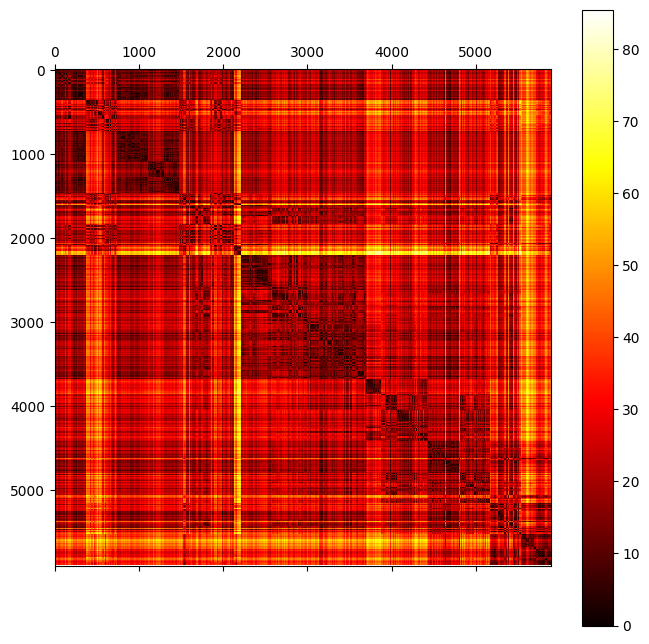

In [5]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(perm_A, cmap='hot')
fig.colorbar(cax)
plt.show()

In [6]:
assert m == hpart['rows']['pi'].size and n == hpart['cols']['pi'].size, print(m, hpart['rows']['pi'].size, n, hpart['cols']['pi'].size)
for level in range(len(hpart['rows']['lk'])):
    avg_rows = np.diff(np.array(hpart['rows']['lk'][level])).mean()
    avg_cols = np.diff(np.array(hpart['cols']['lk'][level])).mean()
    print(f"{level=}, {hpart['rows']['lk'][level].size-1}, {avg_rows=}, {avg_cols=}")

level=0, 1, avg_rows=5893.0, avg_cols=5893.0
level=1, 2, avg_rows=2946.5, avg_cols=2946.5
level=2, 4, avg_rows=1473.25, avg_cols=1473.25
level=3, 8, avg_rows=736.625, avg_cols=736.625
level=4, 16, avg_rows=368.3125, avg_cols=368.3125
level=5, 32, avg_rows=184.15625, avg_cols=184.15625
level=6, 64, avg_rows=92.078125, avg_cols=92.078125
level=7, 128, avg_rows=46.0390625, avg_cols=46.0390625
level=8, 256, avg_rows=23.01953125, avg_cols=23.01953125
level=9, 512, avg_rows=11.509765625, avg_cols=11.509765625
level=10, 1024, avg_rows=5.7548828125, avg_cols=5.7548828125
level=11, 2048, avg_rows=2.87744140625, avg_cols=2.87744140625
level=12, 4096, avg_rows=1.438720703125, avg_cols=1.438720703125
level=13, 5893, avg_rows=1.0, avg_cols=1.0


In [7]:
rel_tol  = 0.000915625
tol = rel_tol * np.linalg.norm(A, ord='fro')
tol

158.89084859746677

In [8]:
A_HODLR, A_HODLR_fillin, bl_sizes, count = mf.build_hodlr(hpart, m, n, A, tol)

100%|██████████| 14/14 [00:43<00:00,  3.14s/it]


In [9]:
assert np.allclose(A_HODLR_fillin, np.ones((m, n)))
np.histogram(A_HODLR_fillin.reshape(-1), bins=5)

(array([       0,        0, 34727449,        0,        0]),
 array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]))

In [10]:
# assert (A_HODLR == 0).sum() == 0, print((A_HODLR == 0).sum())

In [11]:
hodlr_storage = mf.get_hodlr_storage(bl_sizes, count, m, n)

In [12]:
np.histogram(bl_sizes[:, 0]) # rank histogram

(array([17649,    18,     6,     2,     0,     0,     0,     0,     0,
            2]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]))

In [13]:
(bl_sizes[:, 0] == 0).sum(), (bl_sizes[:, 0] == 1).sum()

(11100, 6375)

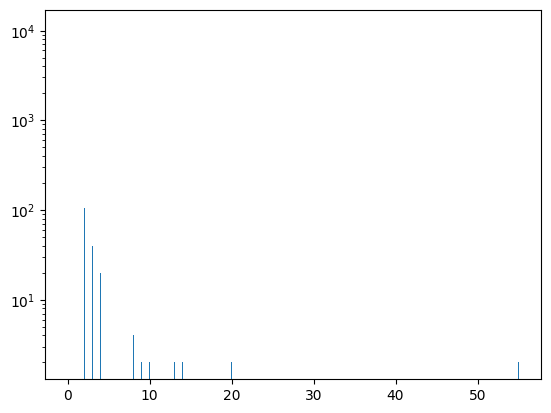

In [14]:
plt.hist(bl_sizes[:, 0], bins='auto')
plt.yscale('log')
plt.show()

In [15]:
(bl_sizes[:,0]==0).sum()

11100

In [16]:
print(f"{rel_tol=},   err={mf.rel_diff(A_HODLR, den=A)},   {hodlr_storage=}")

# rel_tol=0.004880625,err=0.06358474157567166,   hodlr_storage=332585
# rel_tol=0.0026,   err=0.04496502516047404,   hodlr_storage=525119
# rel_tol=0.0015,   err=0.032960322558327204,   hodlr_storage=786757
# rel_tol=0.00095,   err=0.025324894636867826,   hodlr_storage=1126029
# rel_tol=0.000915625,   err=0.024695848284987443,   hodlr_storage=1157821
# rel_tol=0.00088125,   err=0.024338579651191506,   hodlr_storage=1193225
# rel_tol=0.0008125,   err=0.0233110768348484,   hodlr_storage=1267421
# rel_tol=0.000675,   err=0.0208936377895936,   hodlr_storage=1455193
# rel_tol=0.0004,   err=0.015400891435946756,    hodlr_storage=2127725
# rel_tol=0.00025,   err=0.011403348282115823,   hodlr_storage=2948323
# rel_tol=0.000175,   err=0.00852576724897672,   hodlr_storage=3721877
# rel_tol=0.0001,   err=0.004948566334501414,    hodlr_storage=5137477

rel_tol=0.000915625,   err=0.024695848284987443,   hodlr_storage=1157821


In [25]:
40.7 / 6.5

6.261538461538462

In [18]:
print(f"{hodlr_storage/2.=}")
print(f"  {mlr_storage/2.=}")
print(f"       {m * n =}")
mlr_storage * 1./ hodlr_storage

hodlr_storage/2.=578910.5
  mlr_storage/2.=577514.0
       m * n =34727449


0.9975877100173516

In [19]:
# LR                0.007196865828775194
# LR+D              0.007055986378524754
# MLR uni           0.003702024228965611
# MLR bot           0.00664347970941572
# MLR top           0.003928567027860716

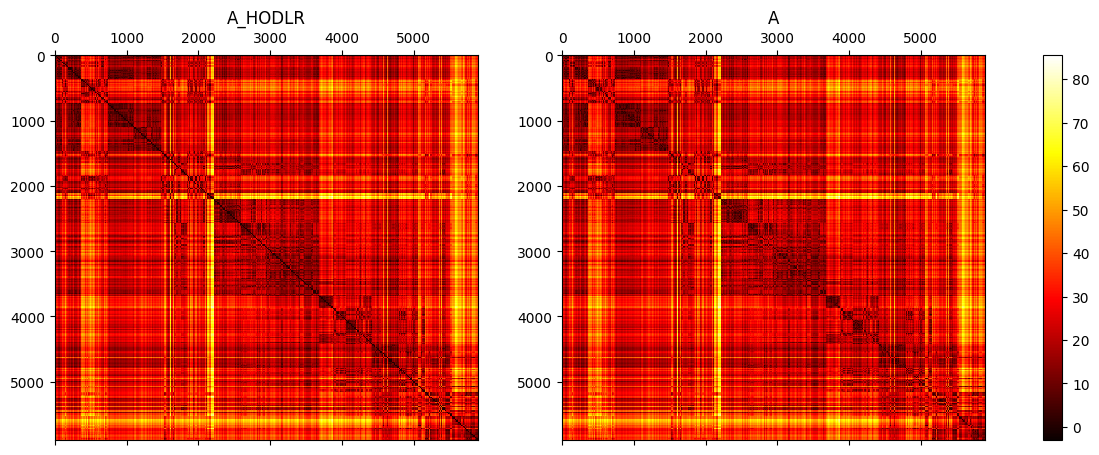

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
vmin = min(A.min(), A_HODLR.min())
vmax = max(A.max(), A_HODLR.max())

cax1 = axs[0].matshow(A_HODLR[hpart['rows']['pi'], :][:, hpart['cols']['pi']], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('A_HODLR')
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax2 = axs[1].matshow(perm_A, cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('A')

fig.colorbar(cax1, ax=axs, orientation='vertical')
plt.show()

In [21]:
a_diags = []
for level in [-1, -2, -3]:
    num_blocks = len(hpart['rows']['lk'][level]) - 1
    a_diags += [np.zeros((m, n))]
    for i, block in enumerate(range(num_blocks)):
        r1, r2 = hpart['rows']['lk'][level][block], hpart['rows']['lk'][level][block+1]
        c1, c2 = hpart['cols']['lk'][level][block], hpart['cols']['lk'][level][block+1]
        a_diags[-1][r1:r2, c1:c2] = 2*np.ones((r2-r1, c2-c1))

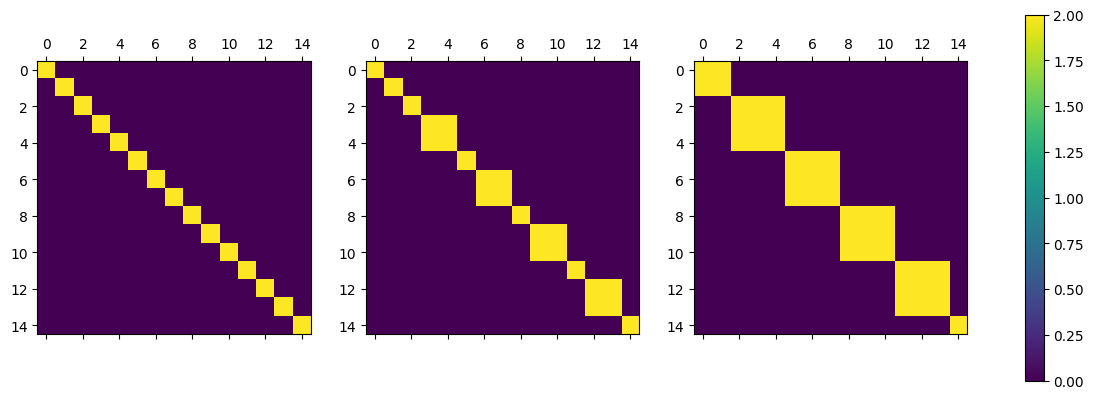

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
max_el = 15
cax1 = axs[0].matshow(a_diags[0][:max_el, :max_el], cmap='viridis')
cax2 = axs[1].matshow(a_diags[1][:max_el, :max_el], cmap='viridis')
cax3 = axs[2].matshow(a_diags[2][:max_el, :max_el], cmap='viridis')

cbar = fig.colorbar(cax2, ax=axs.ravel().tolist(), shrink=0.95)
plt.show()